In [2]:
# import the libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import polars as pl

import xgboost as xgb

In [43]:
# read the dataset
data = pl.read_csv("../data/pullreq_with_code.csv", truncate_ragged_lines=True).to_pandas()
data.head()

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code,
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,0,1,79,0,"""eslint"": ""~3.5.0"",",None
1,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,0,1,175,0,"""version"": ""0.2.1"",",None
2,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,9,104,113,110,3,2,24,1,"\t\t} else if !strings.HasPrefix(name, ""*."") {...",None
3,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,33,27,60,60,0,2,7,1,\ndef numpy_core_numerictypes_transform():\n ...,None
4,6,79189935,379,37917551,compsy,vsv,1,91,91.0,1,...,26,0,26,11,15,3,13,0,"let!(:responses) { [some_response, another_r...",None


In [44]:
list(data.columns)

['id',
 'project_id',
 'github_id',
 'pull_request_id',
 'ownername',
 'reponame',
 'merged_or_not',
 'lifetime_minutes',
 'mergetime_minutes',
 'num_commits',
 'src_churn',
 'test_churn',
 'files_added',
 'files_deleted',
 'files_modified',
 'files_changed',
 'src_files',
 'doc_files',
 'other_files',
 'num_commit_comments',
 'num_issue_comments',
 'num_comments',
 'num_participants',
 'sloc',
 'team_size',
 'perc_external_contribs',
 'commits_on_files_touched',
 'test_lines_per_kloc',
 'test_cases_per_kloc',
 'asserts_per_kloc',
 'watchers',
 'prev_pullreqs',
 'requester_succ_rate',
 'followers',
 'churn_addition',
 'churn_deletion',
 'pr_comment_num',
 'perc_neg_emotion',
 'perc_pos_emotion',
 'perc_neu_emotion',
 'part_num_issue',
 'part_num_commit',
 'part_num_pr',
 'part_num_code',
 'comment_conflict',
 'hash_tag',
 'at_tag',
 'test_inclusion',
 'description_length',
 'bug_fix',
 'ci_exists',
 'ci_latency',
 'ci_build_num',
 'ci_test_passed',
 'ci_failed_perc',
 'ci_first_build_s

In [45]:
data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [46]:
rejected_male = data[data['contrib_gender'] == 'male']
rejected_female = data[data['contrib_gender'] == 'female']

rejected_male = rejected_male[rejected_male['merged_or_not'] == 0]
rejected_female = rejected_female[rejected_female['merged_or_not'] == 0]

print("rejected_male: ", rejected_male.shape[0])
print("rejected_female: ", rejected_female.shape[0])


rejected_male:  7739
rejected_female:  822


In [27]:
# remove accepted requests and remove data where gender is unknown
rejected_data = data.loc[data['merged_or_not'] == 0]
rejected_data = rejected_data.loc[rejected_data['contrib_gender'].notna()]

In [28]:
rejected_data.shape

(60206, 142)

In [29]:
rejected_data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [30]:
# drop columns that we do not need
rejected_data = rejected_data.drop(['ownername', 'reponame', 'id', 'project_id', 'github_id', 'creator_id'], axis=1)

In [31]:
# characteristics are from the paper (https://yuyue.github.io/res/paper/newPR_MSR2020.pdf)
# prepare characteristics to drop (contributor characteristics, project characteristics, are characteristics that the contributor cannot control)
contributor_characteristics = ['acc_commit_num', 'first_pr', 'core_member', 'same_country', 'same_affiliation', 'contrib_open', 'contrib_cons', 'contrib_extra', 'contrib_agree', 'contrib_neur', 'inte_open', 'inte_cons', 'inte_extra', 'inte_neur', 'inte_agree', 'open_diff', 'cons_diff', 'extra_diff', 'agree_diff', 'neur_diff', 'social_strength', 'account_creation_days', 'prior_review_num', 'first_response_time', 'contrib_country', 'inte_country', 'prior_interaction', 'contrib_affiliation', 'inte_affiliation', 'contrib_first_emo', 'inte_first_emo', 'contrib_follow_integrator']
project_characteristics = ['language', 'project_age', 'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num']
unable_to_control = ['followers', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'pr_comment_num', 'num_issue_comments', 'has_comments', 'has_participants', 'inte_comment', 'has_exchange', 'num_comments_con', 'first_close_minutes', 'num_issue_comments', 'num_participants', 'lifetime_minutes', 'ci_exists',  'reviewer_comment', 'contrib_comment', 'contrib_rate_author'] # features that contributor cannot control

In [32]:
# drop unwanted characteristics
rejected_data.drop(contributor_characteristics, axis=1, inplace=True)
rejected_data.drop(project_characteristics, axis=1, inplace=True)
rejected_data.drop(unable_to_control, axis=1, inplace=True)
rejected_data.drop(['pull_request_id', 'first_closer_id', 'last_closer_id'], axis=1, inplace=True)
rejected_data.drop(['mergetime_minutes', 'merged_or_not'], axis=1, inplace=True)

In [33]:
rejected_data.shape

(60206, 131)

In [34]:
# Assign smaller class (female) 1
gender_dict = {'male': 0, 'female': 1}

# Use the map function to replace the 'contrib_gender' column
rejected_data['contrib_gender'] = rejected_data['contrib_gender'].map(gender_dict)
df_majority = rejected_data[rejected_data['contrib_gender']==0]
df_minority = rejected_data[rejected_data['contrib_gender']==1]

df_majority_downsampled = df_majority.sample(len(df_minority), replace=False)

rejected_data = pd.concat([df_majority_downsampled, df_minority])
print(rejected_data['contrib_gender'].value_counts())

contrib_gender
0    5873
1    5873
Name: count, dtype: int64


In [35]:
rejected_data[rejected_data["contrib_gender"] == 0]

,lifetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,...,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code,
12861,59,1,2,0,0,0,1,1,1,0,...,2,0,2,1,1,1,0,0,if (grid.gridHeight - grid.scrollb...,None
50444,3607,2,31,0,0,0,1,1,1,0,...,23,0,23,19,4,1,9,0,"def __init__(self, allowed_keys=None):\n ...",1730819.0
75472,4958,2,4,0,0,0,2,2,2,0,...,2,0,2,1,1,1,32,0,Whenever data is converted from one layout to ...,2830630.0
21362,32260,2,161,0,0,0,18,18,18,0,...,161,0,161,68,93,18,6,0,"require ""ohai/mixin/do_metadata""\n require ...",513929.0
2299,4197,4,60,75,1,0,4,5,4,0,...,25,68,93,84,9,4,3,1,import java.util.regex.Matcher;\nimport java.u...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73448,95,1,3,0,0,0,1,1,1,0,...,3,0,3,2,1,1,3,0,cudaError_t last_err = cudaGetLastError();...,2816270.0
64031,165,1,0,2,0,0,1,1,1,0,...,0,2,2,1,1,1,5,1,"describe('ec', function() {",2402535.0
1300,418,1,5,0,0,0,1,1,1,0,...,5,0,5,5,0,2,17,0,"import glob\n # add the extra vars,...",None
44913,17499,12,77,74,0,0,4,4,2,0,...,41,9,50,49,1,3,16,1,location.Location.get_sun_rise_set_transit,1509582.0


In [36]:
rejected_data[rejected_data["contrib_gender"] == 1]

,lifetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,...,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code,
6,1221,3,6634,1480,90,2,9,101,50,47,...,6586,1480,8066,7684,382,104,11,1,# -*- coding: utf-8 -*-\n\nfrom .datatables im...,None
19,72,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,5,0,"\n <extension point=""org.eclipse.core.content...",None
34,28,3,274,0,0,0,10,10,7,3,...,274,0,274,129,145,5,31,0,"There is a ""Course Settings"" link\n\n ...",None
41,0,1,2,0,0,0,1,1,1,0,...,2,0,2,1,1,1,0,0,if index >= 0:,None
44,1196,1,33,0,0,0,3,3,3,0,...,33,0,33,8,25,8,80,1,"function setView2D(camera, position, conve...",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75846,21,1,2,0,0,0,1,1,1,0,...,2,0,2,1,1,1,6,0,"domain = [('product_tmpl_id', '=',...",2833433.0
75863,0,74,2921,0,0,0,1,1,1,0,...,2921,0,2921,1754,1167,1,96,1,"safaribot.sendMessage(src, ""Top "" + pl...",2833451.0
75874,7091,4,288,0,0,0,9,9,9,0,...,267,0,267,233,34,22,8,1,"children,\n type,\n value,\n getMessage,\...",2833462.0
75881,42,2,48,0,0,0,2,2,2,0,...,48,0,48,42,6,2,29,0,// Adds Cache-Control header\ntype cacheContro...,2833470.0


In [37]:
# encode all the columns that are not numerical, and save their label encoders
encoders = { }
for column in rejected_data.select_dtypes(include=['object']).columns:
    le_col = LabelEncoder()
    le_col.fit(rejected_data[column])
    rejected_data[column] = le_col.transform(rejected_data[column])
    encoders[column] = le_col

In [41]:
rejected_data.columns


Index(['lifetime_minutes', 'num_commits', 'src_churn', 'test_churn',
       'files_added', 'files_deleted', 'files_modified', 'files_changed',
       'src_files', 'doc_files',
       ...
       'src_churn_open', 'test_churn_open', 'code_churn_open',
       'churn_addition_open', 'churn_deletion_open', 'code_chunk_num_open',
       'commits_on_files_touched_close', 'test_inclusion_open', 'added_code',
       ''],
      dtype='object', length=131)

In [15]:
# find correlation to see which features are important
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)

# Use Spearman's rank correlation coefficient instead of Pearson's
corr = correlation_data.corr(method='spearman')

correlation = corr['contrib_gender']
sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])

[('files_changed_open', 0.0006518078122169817),
 ('num_commit_comments', 0.011597921602492064),
 ('num_commits_open', 0.01194603921936918),
 ('requester_succ_rate', 0.012433260938136787),
 ('num_commits', 0.01419396440614744),
 ('doc_files', 0.014823971984899703),
 ('reopen_num', 0.015387234408187117),
 ('reopen_or_not', 0.015420700068640833),
 ('doc_files_open', 0.015589523071954348),
 ('same_user', 0.015822404623131114),
 ('perc_external_contribs', 0.018318063989718573),
 ('files_added', 0.025242164007275955),
 ('comment_conflict', 0.027083269856993993),
 ('team_size', 0.02786524088447105),
 ('files_deleted_open', 0.03444747982482413),
 ('added_code', 0.03477642217431593),
 ('other_files', 0.036091576951636894),
 ('files_added_open', 0.03639264495284852),
 ('perc_contrib_pos_emo', 0.03757007216134644),
 ('files_deleted', 0.04568612842362302),
 ('other_files_open', 0.0507357098324198)]

In [16]:
threshold = 0.02 # moderate relationship or higher
high_correlation = list(filter(lambda x : x[1] >= threshold, sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])))
high_correlation_feat = list(map(lambda x : x[0], high_correlation))
print(high_correlation_feat)

['files_added', 'comment_conflict', 'team_size', 'files_deleted_open', 'added_code', 'other_files', 'files_added_open', 'perc_contrib_pos_emo', 'files_deleted', 'other_files_open']


In [17]:
# get data and clean up data by removing n/a values
USE_CORRELATION = False

if USE_CORRELATION:
    features = high_correlation_feat
    print(features)
else:
    features = rejected_data.columns.tolist()
    # remove the target column
    toremove = ["contrib_gender", "added_code"]
    for i in toremove:
        features.remove(i)

# features = ['account_creation_days',  'contrib_open',  'part_num_issue',  'perc_neu_emotion',  'num_participants',  'perc_pos_emotion',  'ci_test_passed',  'asserts_per_kloc',  'followers',  'num_issue_comments',  'perc_neg_emotion',  'lifetime_minutes',  'test_inclusion',  'ci_exists',  'acc_commit_num',  'core_member',  'num_comments',  'at_tag',  'pushed_delta',  'part_num_commit',  'first_response_time',  'ci_latency',  'project_age',  'ci_build_num',  'first_pr',  'hash_tag',  'test_churn',  'num_commit_comments',  'comment_conflict',  'prev_pullreqs',  'bug_fix',  'churn_deletion',  'has_comments',  'has_participants',  'reviewer_comment',  'contrib_comment',  'inte_comment',  'has_exchange',  'same_country',  'perc_contrib_neu_emo',  'social_strength',  'agree_diff',  'contrib_rate_author',  'inte_open',  'contrib_follow_integrator',  'extra_diff',  'num_comments_con',  'first_close_minutes',  'perc_inte_pos_emo',  'neur_diff',  'perc_contrib_neg_emo',  'perc_inte_neu_emo',  'cons_diff',  'same_affiliation',  'test_inclusion_open',  'perc_inte_neg_emo',  'num_code_comments_con',  'friday_effect',  'test_churn_open',  'other_comment',  'perc_contrib_pos_emo',  'integrator_availability',  'churn_deletion_open']
rejected_data_cleaned = rejected_data[[*features, 'contrib_gender']].dropna()
X = rejected_data_cleaned[features]
y = rejected_data_cleaned['contrib_gender']

In [18]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mutual_info})

mi_df = mi_df.sort_values('Mutual_Info', ascending=False)

print(mi_df)

X['combined_feature'] = X[mi_df.iloc[0, 0]] * X[mi_df.iloc[1, 0]]

                 Feature  Mutual_Info
64          contrib_cons     0.090527
78            inte_agree     0.089371
62   contrib_affiliation     0.085629
127  test_inclusion_open     0.074866
44          ci_build_num     0.074753
..                   ...          ...
23         prev_pullreqs     0.000000
95      has_participants     0.000000
56          pushed_delta     0.000000
20   test_cases_per_kloc     0.000000
0       lifetime_minutes     0.000000

[129 rows x 2 columns]


In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5) 

X_pca = pca.fit_transform(X_scaled)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,0.393737,-1.319028,-0.051900,-0.622430,-0.578777
1,0.992898,1.822293,-0.403476,-0.084298,-0.557332
2,-0.888801,0.326088,-0.118573,-0.182481,-0.262232
3,-0.927934,0.337653,-0.098022,-0.246006,-0.324141
4,-0.940472,0.247226,0.125442,-0.418187,-0.315515


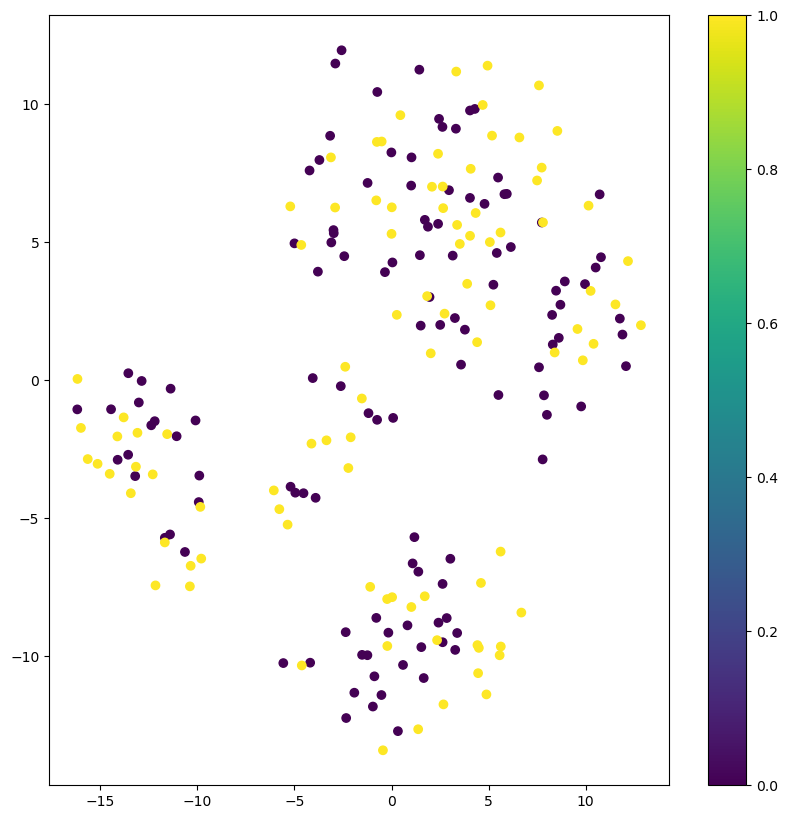

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')

plt.colorbar(scatter)

plt.show()

In [27]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# split into train test val split
train_ratio = 0.80
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio)

# Create a SMOTE object
smote = SMOTE()

# Fit the SMOTE object to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# train the XGBoost classifier model on the balanced training data
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = clf.fit(X_train_resampled, y_train_resampled)
clf.score(X_test, y_test)

/Users/thanosanp/miniconda3/envs/pytorch2/lib/python3.12/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.6046511627906976

Feature ranking:
1. feature prior_review_num (0.05103352665901184)
2. feature files_added_open (0.04779256880283356)
3. feature contrib_extra (0.0467299148440361)
4. feature src_files (0.03788420930504799)
5. feature acc_commit_num (0.037699196487665176)
6. feature combined_feature (0.03521265462040901)
7. feature inte_open (0.032583437860012054)
8. feature churn_deletion (0.032399386167526245)
9. feature num_participants (0.026929905638098717)
10. feature contrib_country (0.025069572031497955)
11. feature sloc (0.023480407893657684)
12. feature ci_latency (0.023317264392971992)
13. feature pushed_delta (0.02156912162899971)
14. feature friday_effect (0.02140786685049534)
15. feature perc_external_contribs (0.018258526921272278)
16. feature requester_succ_rate (0.01816350221633911)
17. feature files_modified_open (0.018114641308784485)
18. feature contrib_neur (0.01712871715426445)
19. feature pr_succ_rate (0.015828877687454224)
20. feature contrib_agree (0.015542509034276009)


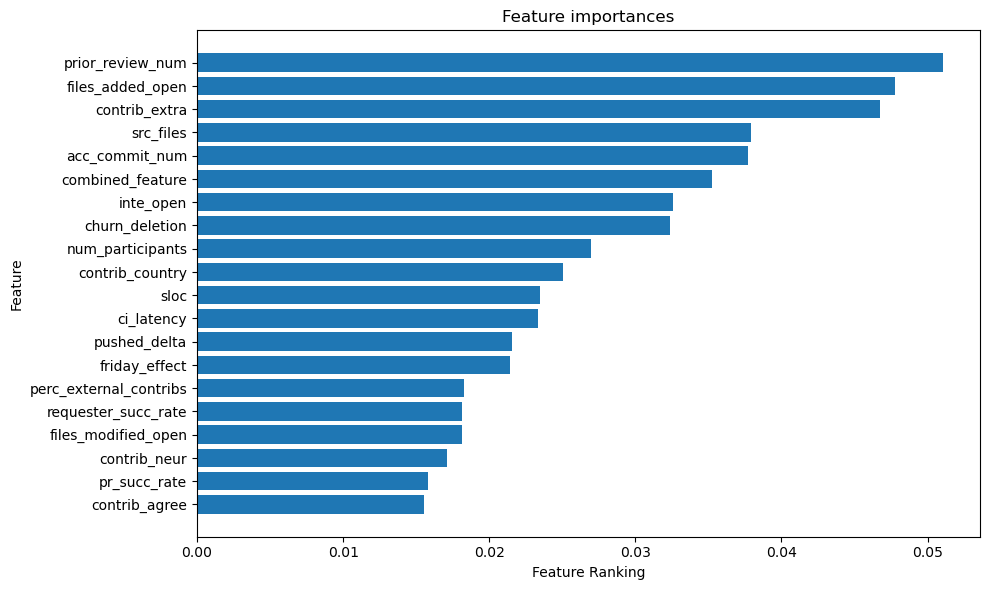

In [28]:
import matplotlib.pyplot as plt
# Get feature importances
importances = clf.feature_importances_

# Map importances to the corresponding feature names and sort them
feature_importances = sorted(zip(importances, X.columns), reverse=True)[:20]

# Print the feature ranking
print("Feature ranking:")

for rank, (importance, name) in enumerate(feature_importances, start=1):
    print(f"{rank}. feature {name} ({importance})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh([name for importance, name in feature_importances], [importance for importance, name in feature_importances])
plt.ylabel("Feature")
plt.xlabel("Feature Ranking")
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature at the top
plt.tight_layout()  # improve spacing
plt.show()

In [29]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight

X_array = X.values
y_array = y.values

scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
clf = XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight, eval_metric='logloss')

kf = StratifiedKFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    X_train, y_train = smote.fit_resample(X_train, y_train)

    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    
    print(classification_report(y_test, predictions, zero_division=0))

/Users/thanosanp/miniconda3/envs/pytorch2/lib/python3.12/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.80      0.40      0.53        10

    accuracy                           0.68        22
   macro avg       0.72      0.66      0.65        22
weighted avg       0.72      0.68      0.66        22

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        12
           1       0.43      0.60      0.50        10

    accuracy                           0.45        22
   macro avg       0.46      0.47      0.45        22
weighted avg       0.47      0.45      0.45        22

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.45      0.56      0.50         9

    accuracy                           0.52        21
   macro avg       0.53      0.53      0.52        21
weighted avg       0.54      0.52      0.53        21

              preci